In [1]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

In [2]:
df = pd.read_csv('Churn_Modelling.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df = df.drop(['RowNumber','CustomerId','Surname'],axis=1)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# Using Label Encoding (better for only two values) for Categorical Data i.e Gender 
label_encoder_gender = LabelEncoder()
df['Gender'] = label_encoder_gender.fit_transform(df['Gender'])

In [6]:
onehotencoder_geography = OneHotEncoder(handle_unknown='ignore')
geo_encoded = onehotencoder_geography.fit_transform(df[['Geography']]).toarray()
geo_encoded_df = pd.DataFrame(geo_encoded, columns=onehotencoder_geography.get_feature_names_out(['Geography']))
geo_encoded_df.head()

,Geography_France,Geography_Germany,Geography_Spain
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


In [7]:
# Concatenating the DataFrames
df = pd.concat([df,geo_encoded_df],axis=1)
df = df.drop(['Geography'],axis=1)
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0


In [8]:
# Splitting the Data
X = df.drop(['EstimatedSalary'],axis=1)
y = df['EstimatedSalary']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
with open('label_encoder_gender.pkl','wb') as f:
    pickle.dump(label_encoder_gender,f)

with open('onehotencoder_geography.pkl','wb') as f:
    pickle.dump(onehotencoder_geography,f)

with open('scaler.pkl','wb') as f:
    pickle.dump(scaler,f)

## ANN Regression Problem Statement

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [13]:
# Creating the Model
model = Sequential([
    Dense(64,activation='relu',input_shape=(X_train.shape[1],)),
    Dense(32,activation='relu'),
    Dense(1)
])

# Compiling the Model
model.compile(optimizer='adam',loss='mean_absolute_error',metrics=['mae'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2945 (11.50 KB)
Trainable params: 2945 (11.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
import datetime

log_dir = "regression_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [18]:
# Training the Model

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, tensorboard_callback]
)

Epoch 1/100


250/250 [==============================] - 3s 5ms/step - loss: 100392.3281 - mae: 100392.3281 - val_loss: 98562.4141 - val_mae: 98562.4141
Epoch 2/100
250/250 [==============================] - 1s 4ms/step - loss: 99767.9766 - mae: 99767.9766 - val_loss: 97278.7891 - val_mae: 97278.7891
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 97511.6094 - mae: 97511.6094 - val_loss: 93946.6016 - val_mae: 93946.6016
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 93010.5156 - mae: 93010.5156 - val_loss: 88291.0938 - val_mae: 88291.0938
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 86305.7266 - mae: 86305.7266 - val_loss: 80851.5859 - val_mae: 80851.5859
Epoch 6/100
250/250 [==============================] - 1s 3ms/step - loss: 78149.9844 - mae: 78149.9844 - val_loss: 72672.8828 - val_mae: 72672.8828
Epoch 7/100
250/250 [==============================] - 1s 4ms/step - loss: 69797.3906 - mae: 69797.390

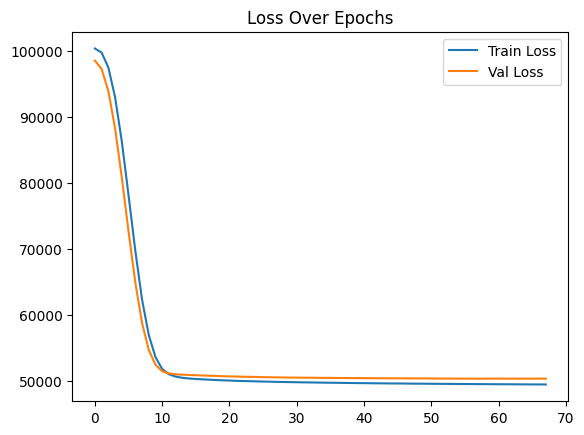

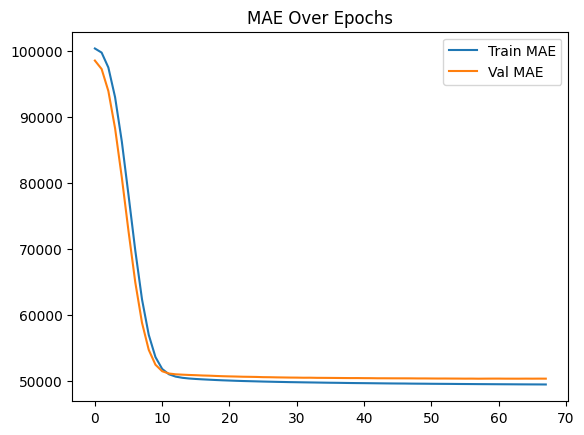

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('MAE Over Epochs')
plt.show()

In [21]:
#Load Tensorboard Extension

%load_ext tensorboard

In [23]:
%tensorboard --logdir regression_logs/fit

Reusing TensorBoard on port 6006 (pid 14116), started 0:00:18 ago. (Use '!kill 14116' to kill it.)

In [24]:
# Evaluating the Model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test MAE: {test_mae:.4f}')

63/63 [==============================] - 0s 2ms/step - loss: 50363.4258 - mae: 50363.4258
Test Loss: 50363.4258
Test MAE: 50363.4258


In [25]:
model.save('regression_model.h5')

e:\Churn_Prediction\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
